In [1]:
import torch, os, re, random
import random, time, os, pytz, argparse, yaml, sys
sys.path.append("../scripts/probing")
sys.path.append("../scripts")
import numpy as np
from probing.probe import *
from tqdm import tqdm, trange
from probing_utils import *
from t5 import *
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = get_tokenizer("google/flan-t5-xxl", dtype=torch.float16)

In [8]:
handle = ""
with open(f"../scripts/probing/ckpts/{handle}/configs.yaml", 'rb') as f: config = yaml.full_load(f.read()) # dict

model = PROBE(
    config['hidden_dim_multipliers'], 
    len(config['relations'].split()), 
    "",
    config['t5_name'], 
    config['t5_dtype']
).to(device)
model.load_state_dict(torch.load(f"../scripts/probing/ckpts/{handle}/model.pt"))

criterion = nn.CrossEntropyLoss().to(device)

In [27]:
texts = ["a lightbulb hangs from the ceiling"]
input_ids = tokenizer.batch_encode_plus(
        texts,
        return_tensors = "pt",
        padding = 'longest',
        max_length = 256,
        truncation = True
    ).input_ids

encoded_text = model.encode_subj_obj(
    texts, 
    [],
    []
)

In [28]:
x = encoded_text.view(-1, model.text_embed_dim) # batch_size*2, dim
x = model.layers(x)
x = model.out(x)
x = x.transpose(0,1)
x.size()

torch.Size([2, 11])

In [29]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.tolist()[0])
print("{:10s} {:6s} {:6s}".format("token", "r", "!r"))
for tok, r, r_ in zip(tokens, x[0], x[1]):
    print("{:10s} {:6.4f} {:6.4f}".format(tok, r.item(), r_.item()))

token      r      !r    
▁          0.4532 -0.5333
a          0.9401 -0.9549
▁light     0.2482 -0.1660
bul        1.4739 -1.4538
b          0.5210 -0.5470
▁hang      0.2923 -0.3299
s          0.4709 -0.4877
▁from      -0.7882 0.7493
▁the       0.6122 -0.5713
▁ceiling   -1.0606 1.0795
</s>       0.0552 -0.0737


#### Plot train-val loss&acc curves with twin y-axes

In [18]:
handles = ["0917_202425", "0917_202659", "0917_202414", "0916_195920", "0917_220347"]
epochs = 10
TrLoss, TrAcc, ValLoss, ValAcc = np.zeros((epochs, len(handles))), np.zeros((epochs, len(handles))), np.zeros((epochs, len(handles))), np.zeros((epochs, len(handles)))

for h, handle in enumerate(handles):
    with open(f"../scripts/probing/ckpts/{handle}/terminal.txt", "r") as f:
        lines = f.readlines()
    i = 0
    while i < len(lines):
        if not "Epoch" in lines[i]: 
            i += 1
            continue
        epoch = int(
            re.match(r"Epoch: (?P<epoch>\d\d) | .*", lines[i].strip()).group('epoch')
        ) - 1
        i += 1
        match = re.match(r"Train Loss: (?P<loss>[\d|\.]+) \| Train Acc: (?P<acc>[\d|\.]+)\%", lines[i].strip())
        TrLoss[epoch][h] = float(match.group('loss'))
        TrAcc[epoch][h] = float(match.group('acc'))
        i += 1
        match = re.match(r"Val\. Loss: (?P<loss>[\d|\.]+) \| +Val\. Acc: (?P<acc>[\d|\.]+)\%", lines[i].strip())
        ValLoss[epoch][h] = float(match.group('loss'))
        ValAcc[epoch][h] = float(match.group('acc'))
        i += 1
print(ValLoss, TrLoss)
    


[[0.635 0.626 0.616 0.615 0.618]
 [0.346 0.338 0.331 0.328 0.332]
 [0.218 0.212 0.207 0.203 0.206]
 [0.15  0.145 0.142 0.138 0.141]
 [0.11  0.106 0.104 0.1   0.102]
 [0.084 0.081 0.079 0.076 0.078]
 [0.067 0.064 0.063 0.06  0.062]
 [0.055 0.052 0.052 0.049 0.05 ]
 [0.046 0.044 0.043 0.04  0.042]
 [0.039 0.037 0.037 0.034 0.035]] [[1.04  1.03  1.023 1.03  1.024]
 [0.466 0.454 0.449 0.453 0.447]
 [0.274 0.264 0.26  0.263 0.258]
 [0.18  0.172 0.17  0.171 0.167]
 [0.128 0.122 0.12  0.121 0.117]
 [0.096 0.091 0.089 0.09  0.087]
 [0.075 0.07  0.069 0.07  0.067]
 [0.06  0.057 0.056 0.056 0.054]
 [0.05  0.047 0.046 0.046 0.044]
 [0.042 0.039 0.038 0.039 0.037]]


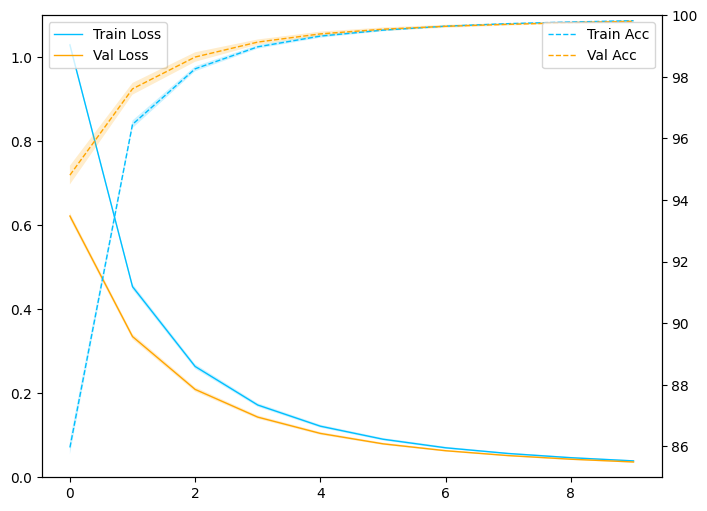

In [31]:
fig, ax1 = plt.subplots(figsize=(8, 6))
x = list(range(epochs))

ax1.set_ylim(0, (int(max(np.max(TrLoss), np.max(ValLoss))*10)+1)/10)
y, yerr = np.mean(TrLoss, axis=1), np.std(TrLoss, axis=1)
ax1.plot(x, y, "-", linewidth=1, label="Train Loss", color="deepskyblue")
ax1.fill_between(x, y-yerr, y+yerr, alpha=0.2, facecolor="deepskyblue")
y, yerr = np.mean(ValLoss, axis=1), np.std(ValLoss, axis=1)
ax1.plot(x, y, "-", linewidth=1, label="Val Loss", color="orange")
ax1.fill_between(x, y-yerr, y+yerr, alpha=0.2, facecolor="orange")

ax2 = ax1.twinx()  
ax2.set_ylim(int(min(np.min(TrAcc), np.min(ValAcc))), 100)
y, yerr = np.mean(TrAcc, axis=1), np.std(TrAcc, axis=1)
ax2.plot(x, y, "--", linewidth=1, label="Train Acc", color="deepskyblue")
ax2.fill_between(x, y-yerr, y+yerr, alpha=0.2, facecolor="deepskyblue")
y, yerr = np.mean(ValAcc, axis=1), np.std(ValAcc, axis=1)
ax2.plot(x, y, "--", linewidth=1, label="Val Acc", color="orange")
ax2.fill_between(x, y-yerr, y+yerr, alpha=0.2, facecolor="orange")

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()